# DiploDatos 2021


### Categorización de publicaciones de productos realizadas en Mercado Libre

### 03 - Introducción al Aprendizaje Automático

#### Condiciones generales que aplican a todos los prácticos:
   - Las notebooks tienen que ser 100% reproducibles, es decir al ejecutar las celdas tal cuál como se entrega la notebook se deben obtener los mismos resultados sin errores.
   - Código legible, haciendo buen uso de las celdas de la notebook y en lo posible seguir estándares de código para *Python* (https://www.python.org/dev/peps/pep-0008/).
   - Utilizar celdas tipo *Markdown* para ir guiando el análisis.
   - Limpiar el output de las celdas antes de entregar el notebook (ir a `Kernel` --> `Restart Kernel and Clear All Ouputs`).
   - Incluir conclusiones del análisis que se hizo en la sección "Conclusiones". Tratar de aportar valor en esta sección, ser creativo.

## 1. Consignas

**Opcional**

Entregar la solución en scripts de *Python*. Se lo puede separar al proyecto en `data.py`, `models.py`, `metrics.py`, `train.py`, etc.

#### Sección 0: División en *train set* y *test set*

- Dividir en entrenamiento (80%) y test (20%).

#### Sección 1:

Tomamos lo generado en el TP anterior. Por lo tanto, partir de lo ya hecho para tener:

- *Sequences*

- *Labels*

- Capa de *Embedding*

(Tener en cuenta que la *tokenización* se hace por separado en los conjuntos de entrenamiento y test, para evitar *leakage* de datos).

#### Sección 2: División en *train set* y *validation set*

- Dividir al conjunto de entrenamiento en entrenamiento y validación utilizando el método de *Stratified K-Folds* (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

#### Sección 3: Entrenamiento de un modelo

- Realizar el entrenamiento de un modelo.

- Se aconseja comenzar por una red neuronal *feed forward*, y/o capas del tipo *LSTM*.

- La primera capa de la red será la *embedding_layer* que ya hayan definido y la última capa será una capa densa con `cantidad de neuronas == cantidad de clases` y función de activación *softmax*.

- Entrenar modelos que utilicen tanto los embeddings pre-entrenados como los customs.

- Experimentar utilizando *dropout* y *batch normalization*.

- Utilizar *checkpoints* para guardar el modelo.

- Utilizar como *loss* la *sparse_categorical_crossentropy*, y se recomienda utilizar *Adam* como *optimizer*.

#### Sección 4: Evaluación del modelo

- Graficar curvas de *loss* y *accuracy* para entrenamiento y validación (se puede hacer utilizando el *model history* de *Keras*, https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History).

- Utilizar *balance accuracy* para medir la performance del modelo en validación y test, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html.

- Diferenciar el *score* según *label_quality*. Es decir, calcular el puntaje para el conjunto de validación y test separando según *reliable* y *unreliable*.

#### Sección 5: Análisis de resultados

- Realizar análisis de que modelo performó mejor, generar un `.csv` con los resultados en validación y test de cada modelo.

#### Sección 6: Exportado de predicciones

- Generar un *dataframe* con las predicciones del conjunto de test del mejor modelo, y exportarlo a un `.csv`.

## 2. Código y análisis

Instalaciones necesarias

In [1]:
!pip install Unidecode

Importaciones necesarias

In [2]:
import pandas as pd
import numpy as np

Lectura de dataset reducido

In [3]:
df_dataset = pd.read_csv('DataSet/dataset.csv')

Estudiamos el dataset brevemente antes de comenzar a operar sobre el mismo.

In [4]:
df_dataset.describe()

,title,label_quality,language,category
count,646760,646760,646760,646760
unique,646019,2,2,20
top,Teclado Casio Ctk4200,unreliable,portuguese,PANTS
freq,2,551878,328992,35973


In [5]:
classes = np.sort(df_dataset.category.unique())

print(f'Dimensiones: {df_dataset.shape}')
print('----------')
print(f'Variables: {list(df_dataset.columns)}')
print('----------')
print(f'Categorías: {list(classes)}')

Dimensiones: (646760, 4)
----------
Variables: ['title', 'label_quality', 'language', 'category']
----------
Categorías: ['BABY_CAR_SEATS', 'BABY_STROLLERS', 'COFFEE_MAKERS', 'ELECTRIC_DRILLS', 'HAIR_CLIPPERS', 'KITCHEN_SINKS', 'MATTRESSES', 'MEMORY_CARDS', 'MOTORCYCLE_JACKETS', 'MUSICAL_KEYBOARDS', 'PANTS', 'PUREBRED_DOGS', 'RANGES', 'REFRIGERATORS', 'ROLLER_SKATES', 'SEWING_MACHINES', 'SHORTS', 'SUITCASES', 'WALL_CLOCKS', 'WINES']


**Sección 0**

In [6]:
from utils import cleaning

df_dataset['clean_title'] = df_dataset.title.apply(cleaning)

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_dataset, train_size=0.8, test_size=0.2, random_state=123)

print(f'Dimensiones Entrenamiento: {df_train.shape}')
print(f'Dimensiones Evaluación: {df_test.shape}')

Dimensiones Entrenamiento: (517408, 5)
Dimensiones Evaluación: (129352, 5)


In [8]:
# Datos de Entrenamiento
X_train = df_train.clean_title.values
y_train = df_train.category.values
# Datos de Test
X_test = df_test.clean_title.values
y_test = df_test.category.values

**Sección 1**

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

word_tokenizer = Tokenizer()
# Aprendemos el Tokenizer en base a los datos de entrenamiento.
word_tokenizer.fit_on_texts(X_train)
# Longitud del Vocabulario en base a los datos de entrenamiento.
vocab_length = len(word_tokenizer.word_index) + 1

embedded_sentences_train = word_tokenizer.texts_to_sequences(X_train)
embedded_sentences_test = word_tokenizer.texts_to_sequences(X_test)

padded_sentences_train = pad_sequences(embedded_sentences_train, padding='post')
# Longitud de Sentencias en base a los datos de entrenamiento.
ammount_sentences, sentences_length = padded_sentences_train.shape

padded_sentences_test = pad_sequences(embedded_sentences_test, padding='post', maxlen=sentences_length)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(classes)

encoded_labels_train = le.transform(y_train)
encoded_labels_test = le.transform(y_test)

In [11]:
from keras.layers.embeddings import Embedding

dense_vector_size = 30
embedding_layer = Embedding(vocab_length, dense_vector_size, input_length=sentences_length)

**Observación**

Solo trabajaremos con *custom embeddings* por dificultades encontradas al adaptar el modelo a los *word vectors* preentrenados de **fastText**.
Una tarea que quedará pendiente, será replantear el uso de esta herramienta.

**Sección 2**

In [12]:
from sklearn.model_selection import StratifiedKFold

splits = 3
kf = StratifiedKFold(splits)

In [14]:
from cross_validation import cross_training
from models import NN_Baseline_Model, NN_Dropout_Model, NN_Batch_Model

m1 = NN_Baseline_Model(embedding_layer, classes)
m2 = NN_Dropout_Model(embedding_layer, classes)
m3 = NN_Batch_Model(embedding_layer, classes)

models = [
          {'name': m1.name, 'model': m1.model},
          {'name': m2.name, 'model': m2.model},
          {'name': m3.name, 'model': m3.model},
          ]

for dict_model in models:
  mean_loss, mean_accuracy = cross_training(dict_model['model'],
                                            kf.split(X_train, y_train),
                                            padded_sentences_train,
                                            encoded_labels_train)
  
  print(f'{dict_model["name"]}:')
  print(f'\tMean Loss {mean_loss}')
  print(f'\tMean Accuracy {mean_accuracy}')

10780/10780 [==============================] - 291s 27ms/step - loss: 0.0420 - accuracy: 0.9891
Neural Network Baseline:
	Mean Loss 0.05127170433600744
	Mean Accuracy 0.9866527120272318
10780/10780 [==============================] - 311s 29ms/step - loss: 0.0285 - accuracy: 0.9933
Neural Network Dropout:
	Mean Loss 0.026133301357428234
	Mean Accuracy 0.9937302867571512
10780/10780 [==============================] - 313s 29ms/step - loss: 0.0209 - accuracy: 0.9947
Neural Network Batch:
	Mean Loss 0.0245552696287632
	Mean Accuracy 0.9936549067497253


**Sección 3**

In [ ]:
history = model.fit(padded_sentences_train, encoded_labels_train, batch_size=128, epochs=5, verbose=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()

# TODO: Definición arbitraria del modelo (pero parece funcionar bien!).
model.add(embedding_layer)
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Flatten())
model.add(Dense(len(classes), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 30)            2594550   
_________________________________________________________________
dense (Dense)                (None, 22, 256)           7936      
_________________________________________________________________
dense_1 (Dense)              (None, 22, 128)           32896     
_________________________________________________________________
flatten (Flatten)            (None, 2816)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                56340     
Total params: 2,691,722
Trainable params: 2,691,722
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Ya que este proceso puede demorar, realizaremos un entrenamiento breve
history = model.fit(padded_sentences_train, encoded_labels_train, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
4043/4043 [==============================] - 180s 41ms/step - loss: 0.9770 - accuracy: 0.7178
Epoch 2/5
4043/4043 [==============================] - 169s 42ms/step - loss: 0.0441 - accuracy: 0.9890
Epoch 3/5
4043/4043 [==============================] - 170s 42ms/step - loss: 0.0235 - accuracy: 0.9942
Epoch 4/5
4043/4043 [==============================] - 167s 41ms/step - loss: 0.0146 - accuracy: 0.9963
Epoch 5/5
4043/4043 [==============================] - 171s 42ms/step - loss: 0.0109 - accuracy: 0.9973


**Sección 4**

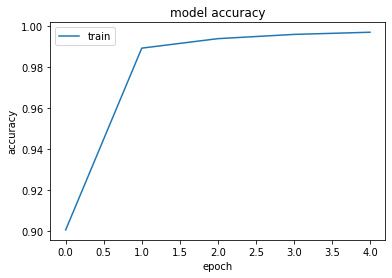

In [ ]:
from matplotlib import pyplot as plt

plt.title('model accuracy')
plt.plot(history.history['accuracy'])

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

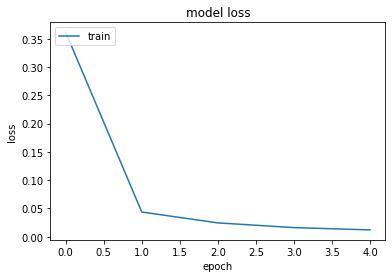

In [ ]:
plt.title('model loss')
plt.plot(history.history['loss'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(padded_sentences_test, encoded_labels_test, batch_size=128, verbose=0)

print(f'Accuracy: {accuracy}')

Accuracy: 0.9861231446266174


In [ ]:
from sklearn.metrics import balanced_accuracy_score

probabilities = model.predict(padded_sentences_test, verbose=0)
predictions = np.argmax(probabilities, axis=-1)

print(f'Balanced Accuracy: {balanced_accuracy_score(encoded_labels_test, predictions)}')

Balanced Accuracy: 0.9860980250073513


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(encoded_labels_test, predictions, target_names=classes))

                    precision    recall  f1-score   support

    BABY_CAR_SEATS       0.98      0.97      0.98      6709
    BABY_STROLLERS       0.97      0.98      0.97      6219
     COFFEE_MAKERS       0.99      0.99      0.99      6968
   ELECTRIC_DRILLS       0.99      0.99      0.99      6304
     HAIR_CLIPPERS       0.98      0.99      0.98      6421
     KITCHEN_SINKS       1.00      0.99      0.99      6242
        MATTRESSES       0.99      0.99      0.99      6546
      MEMORY_CARDS       0.99      0.98      0.99      6139
MOTORCYCLE_JACKETS       0.99      0.99      0.99      6500
 MUSICAL_KEYBOARDS       0.99      0.99      0.99      6671
             PANTS       0.97      0.98      0.98      7225
     PUREBRED_DOGS       0.97      0.99      0.98      6606
            RANGES       0.99      0.99      0.99      6553
     REFRIGERATORS       0.99      0.99      0.99      6469
     ROLLER_SKATES       1.00      0.99      0.99      6329
   SEWING_MACHINES       0.98      0.98

**Sección 5**

In [ ]:
# TO DO

**Sección 6**

In [ ]:
test_title = df_test.title
test_prediction = le.inverse_transform(predictions)

submission = pd.DataFrame(list(zip(test_title, test_prediction)), columns=['title', 'category'])
submission.to_csv('DataSet/dataset_submission.csv', header=True, index=False)

## 3. Conclusiones

In [ ]:
# TO DO